# Final version of the Xception classifier

In this document the final iteration of the classifier within a tensorflow approach for the Wastewise app is carried out. The used code will be briefly explained.

While my other AI team member focused on comparing different pretrained models for our use-case, I opted to only train one: the Xception model with imagenet weights. The goal is to fine-tune the model to acceptable level of accuracy on the validation dataset and to dive deeper with XAI techniques to better understand why a certain prediction was made. 

This first cell imports tensorflow and checks whether any local GPU is available for use.

In [1]:
import tensorflow as tf

# setup a single GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
     # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')        
        gpu_config  = tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [gpu_config])
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


Here the necessary libraries for the training of the CNN are imported. Additionally, a data directory is given for the model to access.

In [11]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras_lr_finder

In [4]:
data_dir = ".../project/data_20_classes"

Since not all images format are acceptable, this function checks whether the images in directory have an acceptable format for tensorflow.

In [5]:
#this code checks if the data is an image file in the given formats
#also checks if the files are compatible with tensorflow
from pathlib import Path
import imghdr


image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

Here the name of the classes are outputted according to the names of the folders in the data directory. 

In [7]:
#get the class names from the data directory
class_names = os.listdir(data_dir)
print(class_names)

['aluminum_foil', 'apples', 'banana_peels', 'cardboard', 'condoms', 'diapers', 'food_waste', 'glass_bottle', 'old_books', 'oranges', 'pans', 'pizza_box', 'plastic_bags', 'plastic_packaging', 'plastic_toys', 'smartphone', 'tampons', 'tea_bags', 'tetrapack', 'toothbrush']


Here we define the batch-size and image size suitable for the model we chose to fine-tune (Xception).
With the function tf.keras.preprocessing.image_dataset_from_directory we can extract the image data from the directory and preprocess them to make them suitable for Xception. Additionally, the data is shuffled and divided in training and validation data set.

In [8]:
# Set the batch size and image size
batch_size = 16
img_size = (299, 299)


# Create a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    #channels of the images
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)


Found 620 files belonging to 20 classes.
Using 496 files for training.
Found 620 files belonging to 20 classes.
Using 124 files for validation.


Class names are outputted to ensure that they are correct.

In [9]:
val_ds.class_names

['aluminum_foil',
 'apples',
 'banana_peels',
 'cardboard',
 'condoms',
 'diapers',
 'food_waste',
 'glass_bottle',
 'old_books',
 'oranges',
 'pans',
 'pizza_box',
 'plastic_bags',
 'plastic_packaging',
 'plastic_toys',
 'smartphone',
 'tampons',
 'tea_bags',
 'tetrapack',
 'toothbrush']

An example image is extracted from a batch and outputted with as title the one hot encoded labels.

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


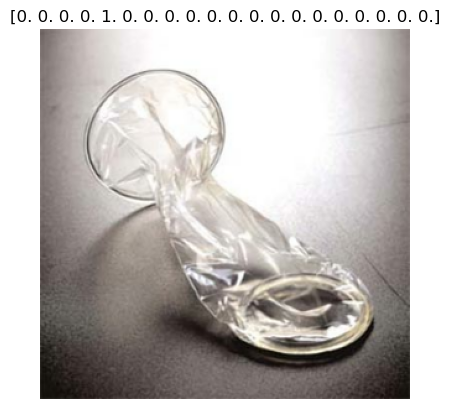

In [10]:
# Take batch of images and labels
for images, labels in train_ds.take(4):
    # Convert batch to NumPy array
    np_images = images.numpy()
    np_labels = labels.numpy()

# Plot the first image in the array
plt.imshow(np_images[0].astype('uint8'))
plt.axis('off')
plt.title(np_labels[0])
plt.show()


Tensor specs are outputted to check for possible errors. None appears to be there.

In [12]:
#specs of the tensors in the train ds
#first refers to the images
#second to the classes
train_ds.element_spec

(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))

Xception expects normalized images. This function carries this task out.

In [13]:
#normalize the dataset
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

#map method is iterating the normalize function over all the elements of the dataset
train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

Here we define the model that we use. We import the model from keras without its final layers, as we want to retrain it to classify only 20 classes. An average pooling layer, a dense layer and a final dense layer with softmax were added initially. After a few trainings iteration, we realized that overfitting was a problem. Different techniques to prevent overfitting were applied: 
- l2 regularization
- drop out 

This helped but did not fully solve the problem.


In [32]:
#to fix overfitting we apply regularization
#involves adding constraints to the weights of the model to prevent them
#from becoming too large and overfitting the training data
#also a dropout layer was applied

from tensorflow.keras.regularizers import l2

base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dense = tf.keras.layers.Dense(128, activation='relu')(avg)
dropout= tf.keras.layers.Dropout(0.3)(dense)
output = tf.keras.layers.Dense(labels.shape[1], activation="softmax", 
                               kernel_regularizer=l2(0.01), 
                               bias_regularizer=l2(0.01))(dropout)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

Here all the layers inside the Xception model are frozen, excluding for the ones that we added.

In [34]:
#freeze the layers
for layer in base_model.layers:
    layer.trainable = False

An optimizer with an initial reasonable learning rate is defined to apply the lr_finder function according to the paper “Cyclical Learning Rates for Training Neural Networks” by Leslie Smith.
Additionally, a suitable loss function for our multiclassification problem is given. Concerning the evaluation metrics, we opted for accuracy.

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

x_train (data) and y_train (labels) are extracted from the data set for the lr_finder.

In [36]:
# Extract x_train and y_train from the train_ds dataset
x_train = []
y_train = []
for data in train_ds.as_numpy_iterator():
    x_train.append(data[0])
    y_train.append(data[1])
x_train = tf.concat(x_train, axis=0)
y_train = tf.concat(y_train, axis=0)

Here the lr_function is carried out with a search range from 1e-6 to 1 for 50 epochs.

In [37]:
lr_finder = keras_lr_finder.LRFinder(model)
lr_finder.find(x_train, y_train, batch_size=batch_size,
               start_lr=1e-6, end_lr=1, epochs=50)

Epoch 1/50
31/31 [==============================] - 13s 328ms/step - loss: 3.3214 - accuracy: 0.0786
Epoch 2/50
31/31 [==============================] - 10s 330ms/step - loss: 3.3114 - accuracy: 0.0867
Epoch 3/50
31/31 [==============================] - 10s 330ms/step - loss: 3.2880 - accuracy: 0.0827
Epoch 4/50
31/31 [==============================] - 10s 330ms/step - loss: 3.2950 - accuracy: 0.0907
Epoch 5/50
31/31 [==============================] - 10s 332ms/step - loss: 3.2728 - accuracy: 0.1028
Epoch 6/50
31/31 [==============================] - 10s 331ms/step - loss: 3.2490 - accuracy: 0.0927
Epoch 7/50
31/31 [==============================] - 10s 335ms/step - loss: 3.2535 - accuracy: 0.1109
Epoch 8/50
31/31 [==============================] - 11s 352ms/step - loss: 3.2315 - accuracy: 0.1431
Epoch 9/50
31/31 [==============================] - 11s 344ms/step - loss: 3.1947 - accuracy: 0.1512
Epoch 10/50
31/31 [==============================] - 11s 347ms/step - loss: 3.1556 - accura

According to Smith, the optimal learning rate is not at the lowest point of loss, but rather were the loss shows its steepest decline. Therefore, we find a learning rate of 0.0005 to be optimal.

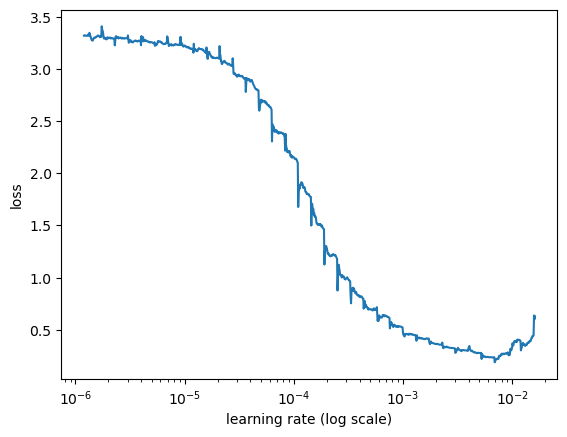

In [38]:
# Plot the learning rate vs. loss curve
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

Now we are ready to train our model and evaluate it. 

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
31/31 [==============================] - 18s 489ms/step - loss: 2.6997 - accuracy: 0.4133 - val_loss: 2.0328 - val_accuracy: 0.7258
Epoch 2/15
31/31 [==============================] - 13s 423ms/step - loss: 1.5128 - accuracy: 0.7903 - val_loss: 1.2226 - val_accuracy: 0.8710
Epoch 3/15
31/31 [==============================] - 13s 426ms/step - loss: 0.9481 - accuracy: 0.9173 - val_loss: 0.9094 - val_accuracy: 0.9032
Epoch 4/15
31/31 [==============================] - 13s 428ms/step - loss: 0.7332 - accuracy: 0.9456 - val_loss: 0.7974 - val_accuracy: 0.8790
Epoch 5/15
31/31 [==============================] - 14s 456ms/step - loss: 0.6210 - accuracy: 0.9617 - val_loss: 0.7291 - val_accuracy: 0.8952
Epoch 6/15
31/31 [==============================] - 14s 451ms/step - loss: 0.5431 - accuracy: 0.9738 - val_loss: 0.6781 - val_accuracy: 0.9274
Epoch 7/15
31/31 [==============================] - 14s 448ms/step - loss: 0.4806 - accuracy: 0.9879 - val_loss: 0.6516 - val_accuracy: 0.9113

The model shows a difference of about 7% between training and validation accuracy. This means that, even if it shows satisfactory results (accuracy > 92% for validation), it is still overfitting. Validation accuracy starts infact stagnating at around epoch number 6.

Considering the we have web-scraped all the training images, it seems reasonable to assume that part of the overfitting is due to the poor quality of the data. First we produce a confusion matrix to see which classes seem to be the most problematic to classify. 

In [40]:
y_true = []
y_pred = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

cm = tf.math.confusion_matrix(y_true, y_pred)

1/1 [==============================] - 0s 31ms/step


9 images out of 124 are misclassified. The most problematic class seem to be "toothbrush" class in which 2 out 4 are not classified correctly.

<AxesSubplot: >

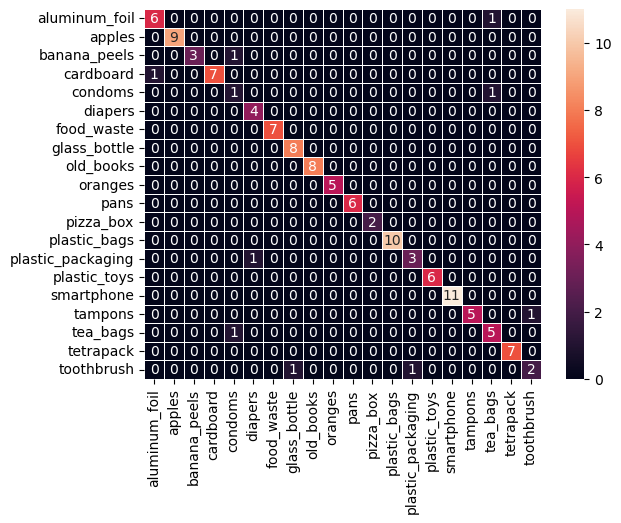

In [41]:
sns.heatmap(cm, annot=True, linewidth=.5, xticklabels=class_names, 
            yticklabels=class_names)

Here we saved the model to import in the app.

In [43]:
#save the model to be imported in the app
model.save('model_20_classes')

INFO:tensorflow:Assets written to: model_20_classes\assets


INFO:tensorflow:Assets written to: model_20_classes\assets


Let´s go more in detail and output all the images that were misclassified, with the corresponding probabilities for correct and wrong class.

1/1 [==============================] - 0s 36ms/step


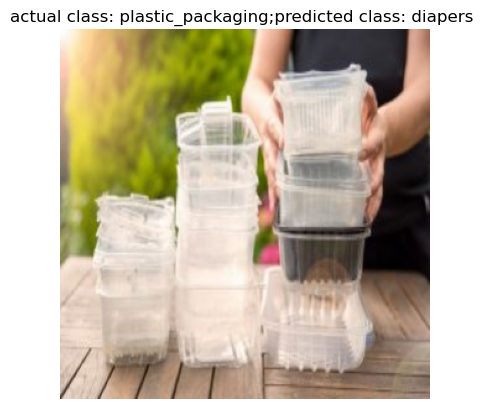

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
probabilities actual: 0.04
probabilities predicted: 0.34
1/1 [==============================] - 0s 40ms/step


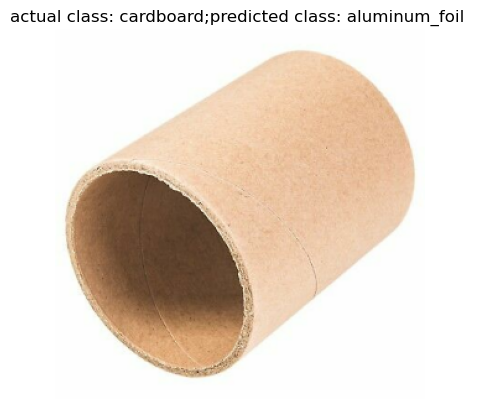

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probabilities actual: 0.19
probabilities predicted: 0.50
1/1 [==============================] - 0s 40ms/step


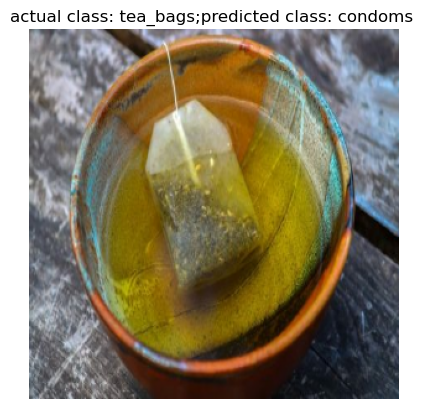

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
probabilities actual: 0.16
probabilities predicted: 0.41


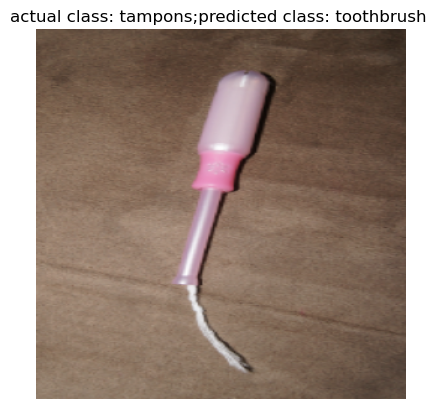

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
probabilities actual: 0.12
probabilities predicted: 0.80
1/1 [==============================] - 0s 44ms/step


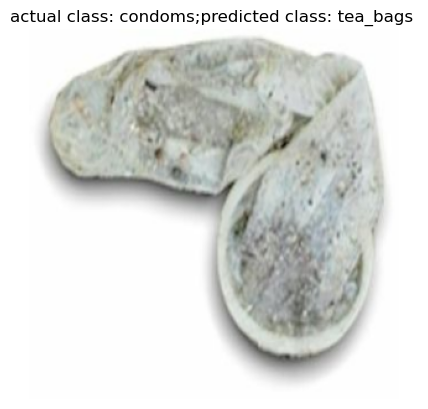

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probabilities actual: 0.04
probabilities predicted: 0.41
1/1 [==============================] - 0s 36ms/step


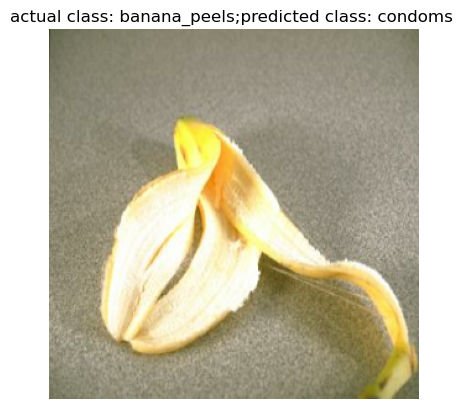

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probabilities actual: 0.23
probabilities predicted: 0.42
1/1 [==============================] - 0s 39ms/step


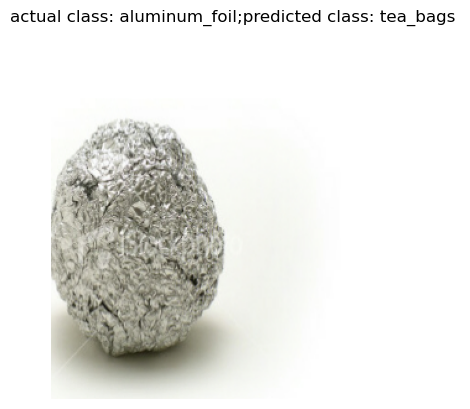

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
probabilities actual: 0.03
probabilities predicted: 0.38


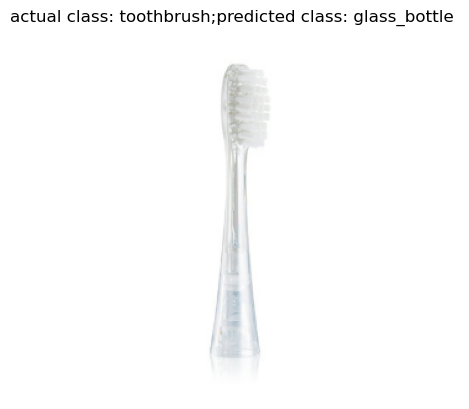

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
probabilities actual: 0.37
probabilities predicted: 0.52


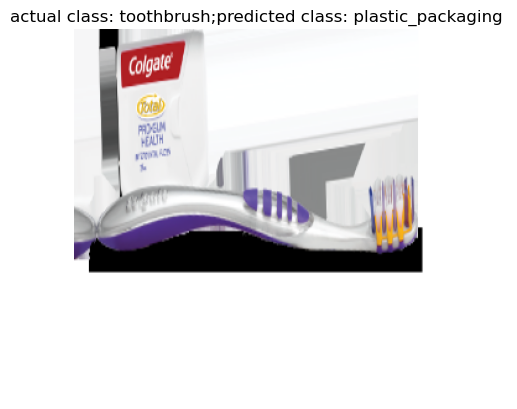

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
probabilities actual: 0.20
probabilities predicted: 0.35


In [42]:
#this code is used for showing the images wiht the lo
for images, labels in val_ds:

    preds = model.predict(images)
    
    # Check if predictions match labels
    idx_mismatch = np.where(np.argmax(labels.numpy(), 
                                      axis=1) != np.argmax(preds, axis=1))[0]
    
    # Plot images with mismatched predictions
    for idx in idx_mismatch:
        np_images = images.numpy()*255
        np_labels = labels.numpy()

        # Display the image
        plt.imshow(np_images[idx].astype('uint8'))
        plt.axis('off')
        plt.title(f"actual class: {class_names[np.argmax(labels.numpy()[idx])]};" 
                  f"predicted class: {class_names[np.argmax(preds[idx])]} ")
        plt.show()
        print(np_labels[idx])
        
        #check if this is correct but it should be 
        
        print(f"probabilities actual: {preds[idx][np.argmax(np_labels[idx])]:.2f}")
        print(f"probabilities predicted: {preds[idx][np.argmax(preds[idx])]:.2f}")

We have a total of 9 misclassified images. For some of them it is rather understandable why the model made an error. For others it is definetely less clear.

In [45]:
from IPython.display import Image, display

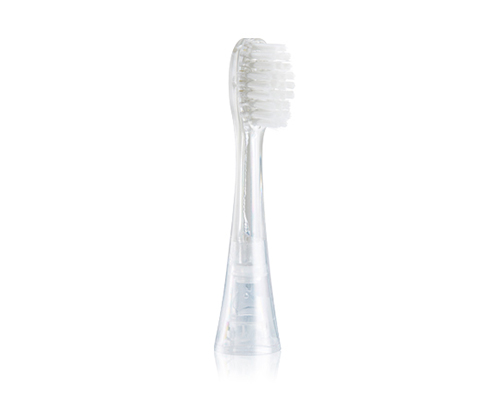

In [21]:
image_path = '.../misclassified_pic/8.jpg'
display(Image(image_path))

This image of a toothbrush was for example classified as a glass bottle. Since it is transparent and has the shape of a bottle neck it is easy to see why such an error was made.

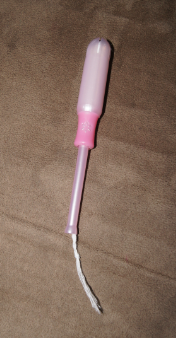

In [46]:
image_path = '.../misclassified_pic/4.png'
display(Image(image_path))

The same is true for this image of a tampon which was classified as a toothbrush. This could be considered a "wrong" image of a tampon, given that it is barely visible inside the plastic encasing. Additionally, the color and the shape match what could be considered a toothbrush.

For other images it is however less clear why the model misclassified them. One important observation has to be made: the data are overall not in high quality and due to the web scraping some objects are not well represented. This is in our view ultimately the cause of the overfitting and the poorer performance of the model in the validation set compared to the training set. 
Still, we thought it may be insightful to apply some XAI algortihms to the the model to better understand some of the least understandable predictions. 


First algortihm that was chosen is Gradient-weighted Class Activation Mapping (Grad-CAM). This is a technique for visualizing and interpreting the activation maps of a convolutional neural network (CNN) by highlighting the regions of an input image that contribute the most to a specific output class.

Here we import the necessary libraries.

In [50]:
import matplotlib.cm as c_map
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import os

We will investigate the picture of plastic packaging that was quite confidently classified as diapers.

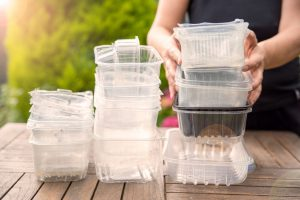

In [51]:
image_path = '.../misclassified_pic/5.jpg'
display(Image(image_path))


In [52]:
#define preprocessing for Xception, img size and last conv layer
preprocess_input = preprocess_input
IMG_SIZE = (299, 299)

#last conv layer is extracted
#later we need this for the class activation maps (CAMs)
last_conv_layer = "block14_sepconv2_act"

In [53]:
#function to vectorize the image
def vectorize_image(img_path, size):
    '''
    Vectorize the given image to get a numpy array
    '''
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0) 
    return array

In [54]:
#feed the image to the model and make a prediction
vectorized_image = preprocess_input(vectorize_image(image_path, size=IMG_SIZE))

model_prediction = model.predict(vectorized_image)
print(f"The predicted class is : {class_names[np.argmax(model_prediction)]}")
print (f"probability is: {np.max(model_prediction)*100:.2f}")

1/1 [==============================] - 1s 690ms/step
The predicted class is : diapers
probability is: 33.68


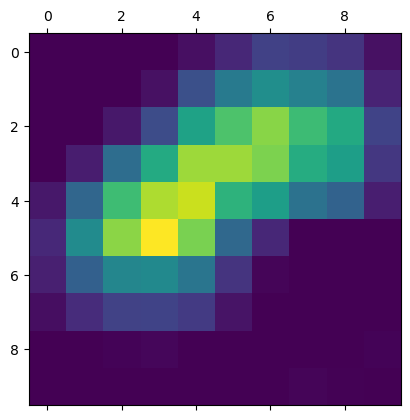

In [55]:
#function for heat map which highlights the most important area on the picture
def get_heatmap(vectorized_image, model, last_conv_layer, pred_index=None):
    '''
    Function to visualize grad-cam heatmaps
    '''
    gradient_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # Gradient Computations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = gradient_model(vectorized_image)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Normalize the heatmap
    return heatmap.numpy()

plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

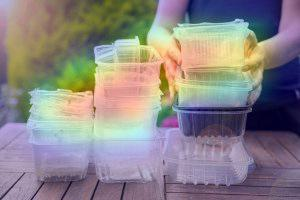

In [56]:
#function to superimpose the heat map on the input image 
def superimpose_gradcam(img_path, heatmap, output_path="grad_cam_image.jpg", alpha=0.4):
    '''
    Superimpose Grad-CAM Heatmap on image
    '''
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap) # Back scaling to 0-255 from 0 - 1
    jet = c_map.get_cmap("jet") # Colorizing heatmap
    jet_colors = jet(np.arange(256))[:, :3] # Using RGB values
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * alpha + img # Superimposing the heatmap on original image
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(output_path) # Saving the superimposed image
    display(Image(output_path)) # Displaying Grad-CAM Superimposed Image
    
superimpose_gradcam(image_path, get_heatmap(vectorized_image, model, last_conv_layer))

Interestingly, it seems that network is focusing mostly on the plastic packaging in the picture. It seems, it may be picking up also on the hands of the person in the photo. A few photo in the diaper data set contain hands, that may be the reason for the misclassification.


Let´s also investigate the same photo with the LIME algorithm. It fits an explainable linear model to the CNN and it uses the coefficients of the linear model to explain the predictions. The output is segmentation (what could consider these superpixels) of the image with the most relevant parts.

In [57]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries


In [58]:
#print out other likely classes
#get order of array based on values, flatten it with ravel 
#and invert it from bigger to smaller

idx_classes = np.argsort(model_prediction).ravel()[::-1]
top_proba = np.sort(model_prediction).ravel()[::-1]
top_classes =  [class_names[i] for i in idx_classes]

print (f"these are the top 3 classes: {top_classes[0:3]}")
print (f"with these probabilities: {top_proba[0:3]*100}")

these are the top 3 classes: ['diapers', 'plastic_bags', 'condoms']
with these probabilities: [33.683    14.113911 12.928221]


In [57]:
#LIME instantiation
explainer = lime_image.LimeImageExplainer(kernel_width=1)

In [58]:
exp = explainer.explain_instance(vectorized_image[0], 
                                 model.predict, 
                                 top_labels=3, 
                                 hide_color=0, 
                                 num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


In [59]:
#score of the explantion
#how good of an approximation is the LIME linear model of the DL model?
#from 0 to 1, can be thought of as an R squared
exp.score

0.8149727574917345

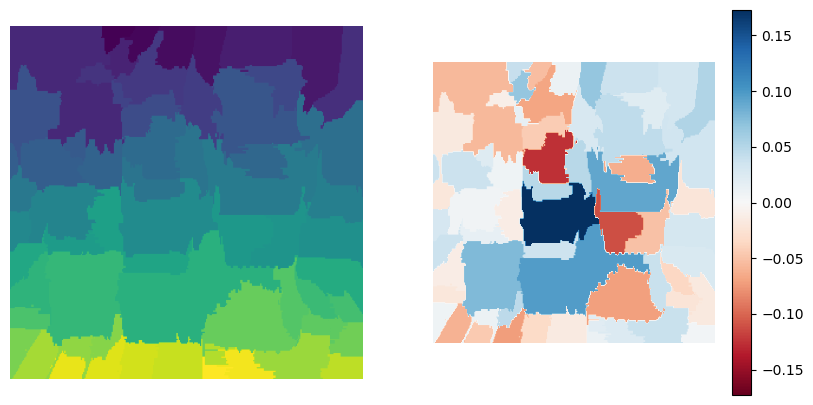

In [60]:
# Plot the image with the superpixel extrapolated by LIME
#the heatmap shows the importance of each superpixel
#here we look at the predicted class
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(exp.segments)
ax[0].axis('off')
dict_heatmap = dict(exp.local_exp[exp.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
im = ax[1].imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), 
                  vmax=heatmap.max())
ax[1].axis('off')
plt.colorbar(im)
plt.show()


In [61]:
#show the 5 most important super pixels
def generate_prediction_sample(exp, exp_class, weight = 0.01, 
                               show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box 
    model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=5, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


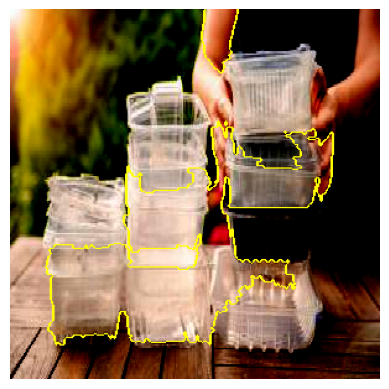

In [62]:
generate_prediction_sample(exp, exp.top_labels[0], 
                           show_positive = True, hide_background = False)

Also according to LIME the model is picking up mostly on the plastic packaging, but also on the hands. The similarity of the packing to the diapers and the inclusion of the hands seems to be likely cause of the misclassification.

Let´s now apply the same algorithms to the photo of a condom that was classfied as tea-bags.

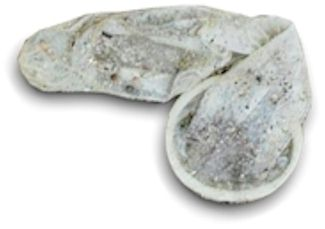

In [59]:
image_path = '.../misclassified_pic/7.jpg'
display(Image(image_path))

In [60]:
#feed the image to the model and make a prediction
vectorized_image = preprocess_input(vectorize_image(image_path, size=IMG_SIZE))

model_prediction = model.predict(vectorized_image)
print(f"The predicted class is : {class_names[np.argmax(model_prediction)]}")
print (f"probability is: {np.max(model_prediction)*100:.2f}")

1/1 [==============================] - 0s 31ms/step
The predicted class is : tea_bags
probability is: 38.34


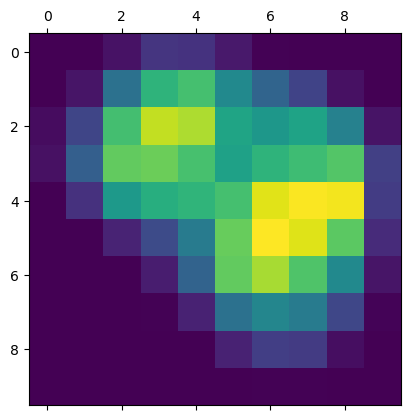

In [66]:
#heat-map
plt.matshow(get_heatmap(vectorized_image, model, last_conv_layer))
plt.show()

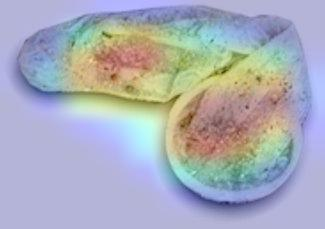

In [67]:
#superposition
superimpose_gradcam(image_path, get_heatmap(vectorized_image, model, last_conv_layer))

In this case the model seems to be focusing on the darker and dirtier areas of the object. After deeper inspection of the tea-bag dataset, some clear similarities appear between the charachteristics of tea-bag photos and the areas highlighted by Grad-CAM.

Let´s see what is the interpretation according to LIME.

In [87]:
#LIME instantiation
explainer = lime_image.LimeImageExplainer()
exp = explainer.explain_instance(vectorized_image[0], 
                                 model.predict, 
                                 top_labels=3, 
                                 hide_color=0, 
                                 num_samples=300)

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


In [88]:
#score of the explantion
#how good of an approximation is the LIME linear model of the DL model?
#from 0 to 1, can be thought of as an R squared
exp.score

0.5895572827145682

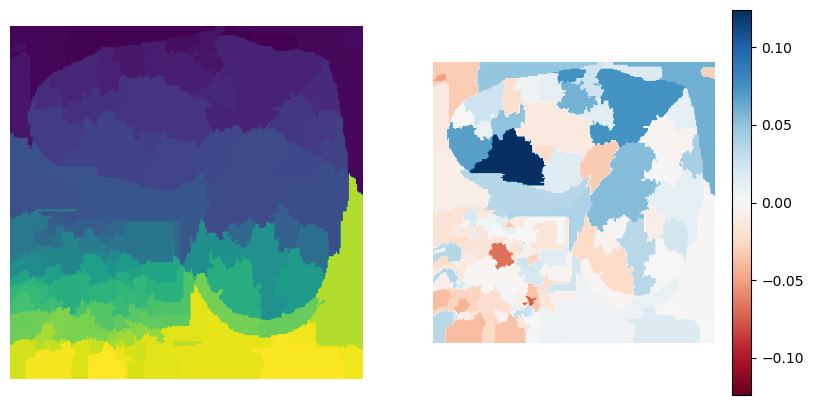

In [89]:
# Plot the image with the superpixel extrapolated by LIME
#the heatmap shows the importance of each superpixel
#here we look at the predicted class
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(exp.segments)
ax[0].axis('off')
dict_heatmap = dict(exp.local_exp[exp.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
im = ax[1].imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), 
                  vmax=heatmap.max())
ax[1].axis('off')
plt.colorbar(im)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


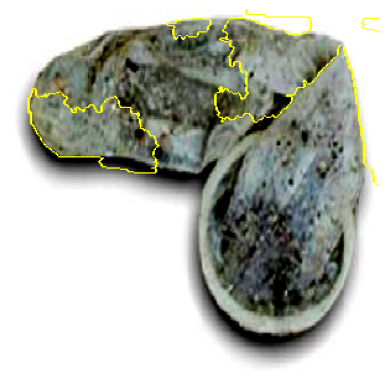

In [90]:
generate_prediction_sample(exp, exp.top_labels[0], 
                           show_positive = True, hide_background = False)

LIME highlights slightly different areas. Nevertheless, also in this case, the highlighted areas keep the similarities to tea-bags that could result in a misclassification of the photo.


In conclsion, it appears that most of the errors are a result of poor data. Data-mismatch with the actual photos of trash by the user is also a big problem for our model. If we are to pursue an actual deployment of the app, beside scaling up the recognized classes, better training data is needed coupled with a possible reinforcement learning with human feedback from the users. This should allow for the model to steadily learn from real-life data and correct itself.
